# Image generation with DCGAN

This notebook shows how to implement a DCGAN based on Gluon. DCGAN is an extension of GANs, where the generator and discriminator are Convolutional Neural Networks (CNN) (see [DCGAN Paper](https://arxiv.org/pdf/1511.06434.pdf)). 
DCGAN learns to draw images based on features it learns from different layers in the network. It can be used for generating natural images. This notebook is based on the DCGAN example from the [Straight Dope Book](https://gluon.mxnet.io/chapter14_generative-adversarial-networks/dcgan.html). 

In [41]:
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2
!pip install mxnet-cu92

--2019-04-04 17:06:02--  https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 192.229.162.216
Connecting to developer.nvidia.com (developer.nvidia.com)|192.229.162.216|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?QRQmWrRHgidRXTGPEYDQ438GYoclgDqmNLLKJu2IyiZEJnCU-uOGDf84zOQHqKm2PxPMC-hjdpe0WfWh1Xxa5j7G2FO6PJQWxpxgUbiqOTDhGuZd59ccP3xoF-Wzf9tuxYnen2QHx9hkwfO5kG-R8U3IPUDJ_mqRi3MydMDgswsxapIuIXriMjEOhVcJepXoePVNZOKAXEsIa87IPws [following]
--2019-04-04 17:06:03--  https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?QRQmWrRHgidRXTGPEYDQ438GYoclgDqmNLLKJu2IyiZEJnCU-uOGDf84zOQHqKm2PxPMC-hjdpe0WfWh1Xxa5j7G2FO6PJQWxpxgUbiqOTDhGuZd59ccP3

In [42]:
!export PATH=/usr/local/cuda-9.2/bin:$PATH
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Wed_Apr_11_23:16:29_CDT_2018
Cuda compilation tools, release 9.2, V9.2.88


In [0]:
from __future__ import print_function
from datetime import datetime
import logging
import multiprocessing
import os
import sys
import tarfile
import time

import numpy as np
from matplotlib import pyplot as plt
import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display

The latent code vector can contain several variables, which can be categorical and/or continuous. We set `n_continuous` to 2 and `n_categories` to 10.

In [0]:
batch_size   = 64
z_dim        = 100
n_continuous = 2
n_categories = 10
ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()

Some functions to load and normalize images.

In [45]:
w = widgets.Dropdown(
    options=['Faces', 'Cartoon', 'Classroom', 'Flowers', ''],
    value='',
    description='Dataset:',
    disabled=False,
    button_style=''
)

display(w)


Dropdown(description='Dataset:', index=4, options=('Faces', 'Cartoon', 'Classroom', 'Flowers', ''), value='')

In [0]:
data_dir = w.value if w.value else 'Faces'

In [47]:
data_url = 'https://s3.amazonaws.com/mxnet-conf-data/GAN_Meetup/'+data_dir+'.tgz'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
data_file = utils.download(data_url)
with tarfile.open(data_file) as tar:
    tar.extractall(path=data_dir)

In [0]:
def transform(data, width=64, height=64):
    data = mx.image.imresize(data, width, height)
    data = nd.transpose(data, (2,0,1))
    data = data.astype(np.float32)/127.5 - 1
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

In [0]:
def get_files(data_dir):
    images    = []
    filenames = []
    for path, _, fnames in os.walk(data_dir):
        for fname in fnames:
            if not fname.endswith('.jpg'):
                continue
            img = os.path.join(path, fname)
            img_arr = mx.image.imread(img)
            img_arr = transform(img_arr)
            images.append(img_arr)
            filenames.append(path + "/" + fname)
    return images, filenames        

Load the dataset `lfw_dataset` which contains images of celebrities.

In [0]:
images, filenames = get_files(data_dir)
split = int(len(images)*0.8)
test_images = images[split:]
test_filenames = filenames[split:]
train_images = images[:split]
train_filenames = filenames[:split]

train_data = gluon.data.ArrayDataset(nd.concatenate(train_images))
train_dataloader = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, last_batch='rollover', num_workers=multiprocessing.cpu_count()-1)

## Generator
Define the Generator model. Architecture is taken from the DCGAN implementation in [Straight Dope Book](https://gluon.mxnet.io/chapter14_generative-adversarial-networks/dcgan.html). The Generator consist of  4 layers where each layer involves a strided convolution, batch normalization, and rectified nonlinearity. It takes as input random noise and the latent code and produces an `(64,64,3)` output image.

In [0]:
class Generator(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Generator, self).__init__(**kwargs)
        with self.name_scope():
            self.G = nn.HybridSequential()
         
            self.G.add(nn.Conv2DTranspose(64 * 8, 4, 1, 0, use_bias=False))
            self.G.add(nn.BatchNorm())
            self.G.add(nn.Activation('relu'))
            self.G.add(nn.Conv2DTranspose(64 * 4, 4, 2, 1, use_bias=False))
            self.G.add(nn.BatchNorm())
            self.G.add(nn.Activation('relu'))
            self.G.add(nn.Conv2DTranspose(64 * 2, 4, 2, 1, use_bias=False))
            self.G.add(nn.BatchNorm())
            self.G.add(nn.Activation('relu'))
            self.G.add(nn.Conv2DTranspose(64, 4, 2, 1, use_bias=False))
            self.G.add(nn.BatchNorm())
            self.G.add(nn.Activation('relu'))
            self.G.add(nn.Conv2DTranspose(3, 4, 2, 1, use_bias=False))
            self.G.add(nn.Activation('tanh'))

    def hybrid_forward(self, F, x):
        x = F.reshape(x, (0, -1, 1, 1))
        return self.G(x)

## Discriminator
Define the Discriminator and Q model. The Q model shares many layers with the Discriminator. Its task is to estimate the code `c` for a given fake image.  It is used to maximize the lower bound to the mutual information.

In [0]:
class Discriminator(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Discriminator, self).__init__(**kwargs)
        with self.name_scope():
            self.D = nn.HybridSequential()
            self.D.add(nn.Conv2D(64, 4, 2, 1, use_bias=False))
            self.D.add(nn.LeakyReLU(0.2))
            self.D.add(nn.Conv2D(64 * 2, 4, 2, 1, use_bias=False))
            self.D.add(nn.BatchNorm())
            self.D.add(nn.LeakyReLU(0.2))
            self.D.add(nn.Conv2D(64 * 4, 4, 2, 1, use_bias=False))
            self.D.add(nn.BatchNorm())
            self.D.add(nn.LeakyReLU(0.2))
            self.D.add(nn.Conv2D(64 * 8, 4, 2, 1, use_bias=False))
            self.D.add(nn.BatchNorm())
            self.D.add(nn.LeakyReLU(0.2))
            self.D.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))

    def hybrid_forward(self, F, x):
          return self.D(x)

The InfoGAN has the following layout.
<img src="https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/info_gan/InfoGAN.png" style="width:800px;height:250px;">

Discriminator and Generator are the same as in the DCGAN example. On top of the Disciminator is the Q model, which is estimating the code `c` for given fake images. The Generator's input is random noise and the latent code `c`.  

## Training Loop
Initialize Generator and Discriminator and define correspoing trainer function.

In [0]:
generator = Generator()
generator.hybridize()
generator.initialize(mx.init.Normal(0.002), ctx=ctx)

discriminator = Discriminator()
discriminator.hybridize()
discriminator.initialize(mx.init.Normal(0.002), ctx=ctx)

lr   = 0.0002
beta = 0.5

g_trainer = gluon.Trainer(generator.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta})
d_trainer = gluon.Trainer(discriminator.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta})

Create vectors with real (=1) and fake labels (=0).

In [0]:
real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

There are 2 differences between InfoGAN and DCGAN: the extra latent code and the Q network to estimate the code.
The latent code is part of the Generator input and it contains mutliple variables (continuous, categorical) that can represent different distributions. In order to make sure that the Generator uses the latent code, mutual information is introduced into the GAN loss term. Mutual information measures how much X is known given Y or vice versa. It is defined as:

![gif](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/info_gan/entropy.gif) 

The InfoGAN loss is:

![gif](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/info_gan/loss.gif)

where `V(D,G)` is the GAN loss and the mutual information `I(c, G(z, c))` goes in as regularization. The goal is to reach high mutual information, in order to learn meaningful codes for the data. 


Define the loss functions. `SoftmaxCrossEntropyLoss` for the categorical code,  `L2Loss` for the continious code and `SigmoidBinaryCrossEntropyLoss` for the normal GAN loss.

In [0]:
loss1 = gluon.loss.SigmoidBinaryCrossEntropyLoss()

This function samples `c`, `z`, and concatenates them to create the generator input.

In [0]:
def create_generator_input():  
    #create random noise
    z      = nd.random_normal(0, 1, shape=(batch_size, z_dim, 1, 1), ctx=ctx)
    return z


def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

Define the training loop. 
1. The discriminator receives `real_data` and `loss1` measures how many real images have been identified as real
2. The discriminator receives `fake_image` from the Generator and `loss1` measures how many fake images have been identified as fake
3. Update Discriminator. Currently, it is updated every second iteration in order to avoid that the Discriminator becomes too strong. You may want to change that.
4. The updated discriminator receives `fake_image` and `loss1` measures how many fake images have been been identified as real, `loss2` measures the difference between the sampled continuous latent code `c` and the output of the Q model and `loss3` measures the difference between the sampled categorical latent code `c` and the output of the Q model.
4. Update Generator and Q

In [0]:
def visualize(img_array):
    plt.imshow(((img_array.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

Epoch 0


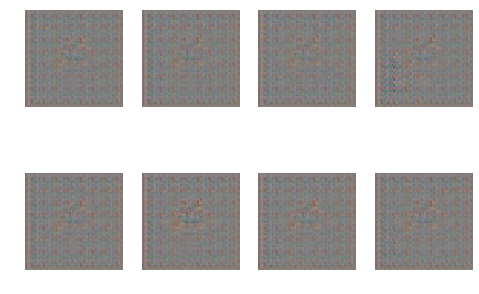

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10


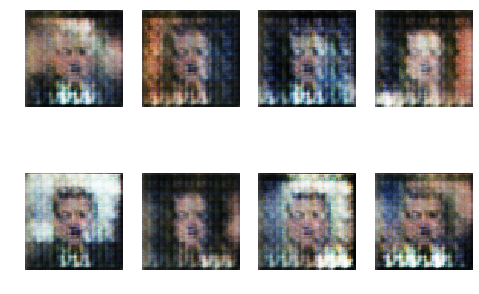

Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20


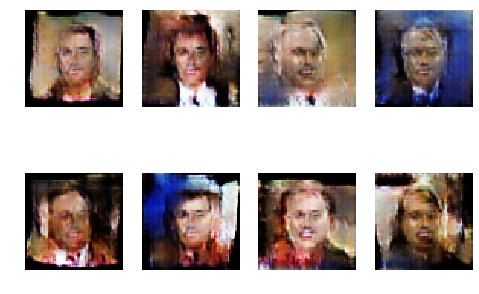

Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30


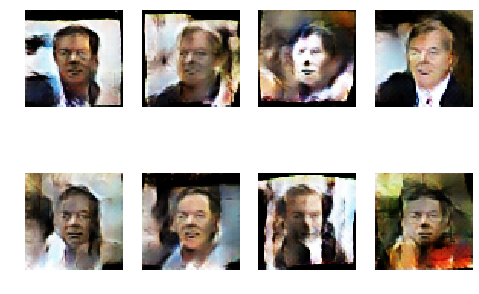

Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40


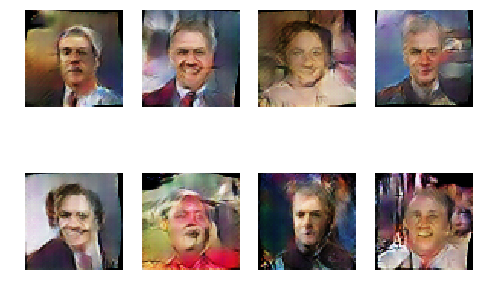

Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49


In [58]:
epochs = 50
counter = 0
for epoch in range(epochs):
    print("Epoch", epoch)
    starttime = time.time()
        
    d_error_epoch = nd.zeros((1,), ctx=ctx)
    g_error_epoch = nd.zeros((1,), ctx=ctx)
        
    for idx, data in enumerate(train_dataloader):
                
        #get real data and generator input
        real_data = data.as_in_context(ctx)     
        g_input = create_generator_input()

            
        #Update discriminator: Input real data and fake data
        with autograd.record():
            output_real = discriminator(real_data)
            d_error_real    = loss1(output_real, real_label)
            metric.update([real_label,], [output_real,])
                
            # create fake image and input it to discriminator
            fake_image = generator(g_input)
            output_fake = discriminator(fake_image.detach())
            d_error_fake = loss1(output_fake, fake_label)                
            # total discriminator error
            d_error = d_error_real + d_error_fake
            d_error.backward()
            metric.update([fake_label,], [output_fake,])

        d_trainer.step(batch_size)

        #Update generator: Input random noise and latent code vector
        with autograd.record():
            fake_image = generator(g_input)
            output_fake = discriminator(fake_image)
            g_error = loss1(output_fake, real_label) #+ loss3(category_prob, label) + loss2(c2, continuous_mean)
            g_error.backward()
            
        g_trainer.step(batch_size)

        # Print log infomation every ten batches
        if idx % 10 == 0:
            count = idx + 1
            name, acc = metric.get()
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - starttime)))
            logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d' 
                     %(nd.mean(d_error).asscalar(),nd.mean(g_error).asscalar(), acc, count, epoch))
        btic = time.time()
        
        discriminator.save_parameters("dcgan_d_latest.params")
        generator.save_parameters("dcgan_g_latest.params")
    name, acc = metric.get()
    metric.reset()
    if epoch % 10 == 0:
        num_image = 8
        for i in range(num_image):
            latent_z = mx.nd.random_normal(0, 1, shape=(1, z_dim, 1, 1), ctx=ctx)
            img = generator(latent_z)
            plt.subplot(2,4,i+1)
            visualize(img[0])
        plt.show()

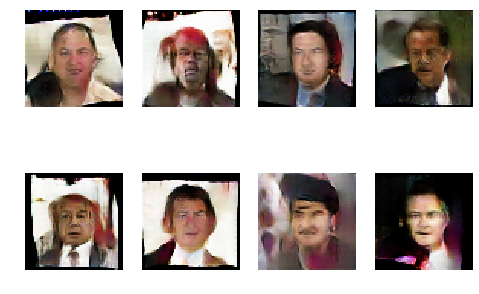

In [59]:
num_image = 8
for i in range(num_image):
    latent_z = mx.nd.random_normal(0, 1, shape=(1, z_dim, 1, 1), ctx=ctx)
    img = generator(latent_z)
    plt.subplot(2,4,i+1)
    visualize(img[0])
plt.show()